In [1]:
import time
import json
import geojson
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull

from itertools import combinations

from cycler import cycler
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Arrow
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.collections import PatchCollection

from pyproj import CRS, Transformer
from pvlib.location import Location
from pvlib.irradiance import get_total_irradiance

import cvxpy as cp
import pyomo.environ as pyo

In [2]:
# Fix random seed
np.random.seed(1234)

# Paths
FILEPATH_FIG = "fig/"

# Figure settings
FIGSIZE_COL_WIDTH = 3.5

latex_preamble = [
    r'\usepackage{amsfonts}',
    r'\usepackage{amssymb}',
    r'\usepackage{amsmath}',
]

plt.rcParams.update({
    "grid.alpha": 0.5,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "legend.frameon": False,
    "ytick.labelsize": 6,
    "xtick.labelsize": 6,
    "font.size": 9,
    "font.family": "sans",
    "font.sans-serif": ["Computer Modern Roman"],
    "text.usetex": True,
    "text.latex.preamble": "".join(latex_preamble)
})

poly_plot_params = {
    "facecolor": "#EEEEEE",
    "edgecolor": "#333333",
    "linewidth": 2
} 

rect_plot_params = {
    "facecolor": "#41b8f0",
    "edgecolor": "#333333",
    "zorder": 0
}

In [3]:
'''
Settings
'''

LAT = 41.3632597
LON = 15.5552962
ALT = 437
TZ  = "Europe/Rome"
ALB = 0.055
START_TIME = "2022-01-01 00:00:00"
END_TIME   = "2022-12-31 23:00:00"

CP   = 75 # Solar panel cost per m2
CR   = 10 # Solar panel mounting unit cost
K    = 4  # Piece-wise circle segments
S    = 35 # Number of iterations

D_OFF = 1.5 # Arrays distance offset
W     = 1.5 # Module width
H     = 3   # Module height

FILTERING       = "operating_hours" # "operating_hours" or "pos_elevation" or "min_elevation"
OPERATING_START = "12:00:00"
OPERATING_END   = "12:00:00"
MAX_POWER       = 3000 # kW
MIN_POWER       = 500 # kW

PROBLEM_NAME = "vasto_giardinetto"
PROBLEM_CURV = "Convex" # "convex" or "nonconvex" 
PROBLEM_TYPE = "power" # "power" or "area"
POLYGON_TYPE = "geoJSON" # "geoJSON" or "random"
GEOJSON_PATH = f"area/{PROBLEM_NAME}_margin.geojson"
VERBOSE      = True

In [4]:
'''
Solvers Parameters
'''

TOTAL_MAX_TIME = 7200

MOSEK_PARAMS = {
    "MSK_DPAR_MIO_MAX_TIME": TOTAL_MAX_TIME / S, # -1
    "MSK_IPAR_MIO_FEASPUMP_LEVEL": -1, # -1
    "MSK_DPAR_MIO_TOL_FEAS": 1e-6, # 1e-6
    "MSK_DPAR_MIO_TOL_REL_GAP": 1e-3 # 1e-10
}

SCIP_PARAMS =  {
    "separating/cgmip/timelimit": 1e+10,
    "limits/gap": 1e-3
}

In [5]:
'''
Utilities
'''

# Coordinate reference systems
wgs84 = CRS.from_string("epsg:4326")
pmerc = CRS.from_string("epsg:3857")
sinus = CRS.from_string("esri:54008")

def time2int(time):
    '''
    Tranform HH:MM:SS to int(HH)
    '''
    return int(time.split(":")[0])

def sun_data(lat, lon, alt, tz, start_time, end_time, filtering="None", freq="H", **kwargs):
    '''
    Get solar data through pvlib
    '''
    times = pd.date_range(start_time, end_time, freq=freq, tz=tz)
    
    # Create location and get solar position over time and clear sky estimates of GHI, DNI, and/or DHI
    location       = Location(lat, lon, altitude=alt)
    solar_position = location.get_solarposition(times)
    clear_sky      = location.get_clearsky(times)
    total_data     = pd.concat([solar_position, clear_sky], axis=1)
    
    if filtering == "pos_elevation":
        total_data = total_data.query(f'elevation > {kwargs["min_elev"]}')
    elif filtering == "operating_hours":
        total_data = total_data.between_time(kwargs["operating_start"], kwargs["operating_end"])
    elif filtering == "min_elevation":
        pos_elev_data = total_data = total_data.query(f'elevation > {kwargs["min_elev"]}')
        total_data = pos_elev_data[pos_elev_data["elevation"] == pos_elev_data["elevation"].min()]
        
    T = total_data.shape[0]
    sun_azmth = np.deg2rad(total_data["azimuth"].to_numpy())
    sun_elev  = np.deg2rad(total_data["elevation"].to_numpy())
    
    # "beam" <-> "dni", "diff" <-> "dhi", "grnd" <-> "ghi", expressed in kW
    dni = 1e-3*total_data["dni"].to_numpy()
    dhi = 1e-3*total_data["dhi"].to_numpy()
    ghi = 1e-3*total_data["ghi"].to_numpy()
    
    return T, sun_azmth, sun_elev, dni, dhi, ghi

def target_power(operating_start, operating_end, T, max_power, min_power):
    '''
    Generate a target power vector, with minimum and maximum requirement for the given operating hours
    '''
    start_hour = time2int(operating_start)
    end_hour   = time2int(operating_end)
    lower_hour = min(start_hour % 12, 12 - end_hour % 12)
    days       = T // (end_hour - start_hour + 1)
    
    m = (max_power - min_power) / (12 - lower_hour)
    q = (12*min_power - lower_hour*max_power) / (12 - lower_hour)
    halfday_target = m*np.arange(13) + q
    fullday_target = np.hstack([halfday_target, halfday_target[11::-1]])
    
    return np.kron(np.ones(days), fullday_target[start_hour:end_hour+1])
      
def vert2con(Vs):
    '''
    Method adapted from Michael Kelder's vert2con() MATLAB function
    http://www.mathworks.com/matlabcentral/fileexchange/7895-vert2con-vertices-to-constraints
    '''
    hull = ConvexHull(Vs)
    K = hull.simplices
    c = np.mean(Vs, 0) # centroid
    V = Vs - c

    A = np.empty((K.shape[0], Vs.shape[1]))
    l = np.empty((K.shape[0], Vs.shape[1]))
    u = np.empty((K.shape[0], Vs.shape[1]))

    rc = 0
    for i in range(K.shape[0]):
        ks = K[i, :]
        F = V[ks, :]
        Fs = Vs[ks,:]
        
        l[rc,:] = np.min(Fs, axis=0)
        u[rc,:] = np.max(Fs, axis=0)

        if np.linalg.matrix_rank(F) == F.shape[0]:
            f = np.ones(F.shape[0])
            A[rc, :] = np.linalg.solve(F, f)
            rc += 1

    A = A[0:rc, :]
    b = np.array([np.dot(A, c) + 1.0])

    return A, b, l, u

def rectangles(x, y, z):
    rects = np.stack([x*z, y*z], axis=2)
    return rects

def geojson_polygon(path):
    '''
    Generates a polygon from a give geojson file
    '''
    with open(path, "r") as file:
        geojson = json.load(file)
        
    # Geojson coordinates are expressed in World Geodetic System 1984 (WGS84) datum,
    # which we convert to the sinudoidal projecton (esri:54008) CRS.
    coor = np.squeeze(geojson["features"][0]["geometry"]["coordinates"])
    x, y = Transformer.from_crs(wgs84, sinus, always_xy = True) \
                      .transform(coor[:,0], coor[:,1], radians=False)
    
    vertices = np.vstack([x, y]).T
    centroid = np.mean(vertices,0)
    vertices = vertices - centroid
    return ConvexHull(vertices), centroid

def random_polygon(initial_V, scale_factor):
    '''
    Generates a polygon, as the convex hull of a random set of points in R2
    '''
    vertices = scale_factor*np.random.rand(initial_V,2)
    centroid = np.mean(vertices,0)
    vertices = vertices - centroid
    return ConvexHull(vertices), centroid

def diameter(Vs):
    '''
    The largest distance between two polygon's vertices
    '''
    return np.max([np.linalg.norm(vi-vj) for vi,vj in combinations(Vs,2)])

def N(P, H, d_off):
    return int((diameter(P) + d_off) // (H + d_off))
    
# Plotting 
def plot_layout(x, y, z, P, savepath=None):
    n = x.shape[0]
    r = rectangles(x, y, z)

    patches = [
        Polygon(P, **poly_plot_params)
    ] 
    patches += [Polygon(r[i,:,:], **rect_plot_params) for i in range(n)]

    fig, ax = plt.subplots(figsize=(FIGSIZE_COL_WIDTH, FIGSIZE_COL_WIDTH))
    p = PatchCollection(patches, match_original=True)
    ax.add_collection(p)
    ax.autoscale_view()
    ax.set_aspect('equal')
    ax.axis("off")

    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show(block=False)
    
def plot_polygon(P, savepath=None):
    fig, ax = plt.subplots(figsize=(FIGSIZE_COL_WIDTH, FIGSIZE_COL_WIDTH))
    p = PatchCollection([
        Polygon(P, **poly_plot_params)
    ], match_original=True)
    ax.add_collection(p)
    ax.autoscale_view()
    ax.set_aspect('equal')
    ax.axis("off")
    
    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show(block=False)

In [6]:
'''
Location and irradiance data
'''

T, sun_azmth, sun_elev, dni, dhi, ghi = sun_data(
    LAT, LON, ALT, TZ, START_TIME, END_TIME, filtering=FILTERING, 
    operating_start=OPERATING_START, operating_end=OPERATING_END,
    min_elev=0
)

print(f"Total hours: {T}")

elev_min = np.min(sun_elev)
tilt_hat = np.arctan(1/np.tan(elev_min))

# Power target
power_spec = target_power(OPERATING_START, OPERATING_END, T, MAX_POWER, MIN_POWER)

Total hours: 365


Area: 20081.74 [m2] Perimeter: 559.38 [m] Diameter: 202.19 [m] N: 45 [arrays]


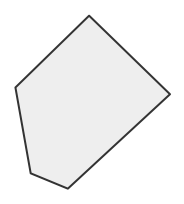

In [7]:
'''
Polygonal area
'''

if POLYGON_TYPE == "random":
    hull, center = random_polygon(initial_V=10,scale_factor=10)
elif POLYGON_TYPE == "geoJSON":
    hull, center = geojson_polygon(GEOJSON_PATH)

P = hull.points[hull.vertices]
V = P.shape[0]

print(f"Area: {hull.volume:.2f} [m2]",
      f"Perimeter: {hull.area:.2f} [m]",
      f"Diameter: {diameter(P):.2f} [m]",
      f"N: {N(P,H,D_OFF)} [arrays]")

# Polygon plotting
plot_polygon(P)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 06:59:00 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 06:59:00 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 06:59:00 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 06:59:00 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Nov 14 06:59:00 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> MOSEK
(CVXPY) Nov 14 06:59:00 PM: Applying reduction Dcp2Cone
(CVXPY) Nov 14 06:59:00 PM: Applying reduction CvxAttr2Constr
(CVX

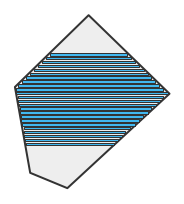

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 06:59:13 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 06:59:13 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 06:59:13 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 06:59:13 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 14 06:59:13 PM: Finished problem compilation (took 7.002e-03 seconds).
-------------------------------------------------------------------------------
                             

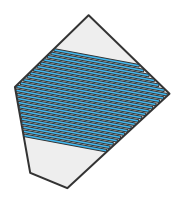

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 06:59:19 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 06:59:19 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 06:59:19 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 06:59:19 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 14 06:59:19 PM: Finished problem compilation (took 5.000e-03 seconds).
-------------------------------------------------------------------------------
                             

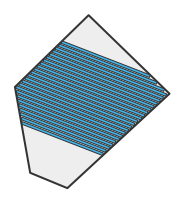

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 06:59:24 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 06:59:24 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 06:59:24 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 06:59:24 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 14 06:59:24 PM: Finished problem compilation (took 6.001e-03 seconds).
-------------------------------------------------------------------------------
                             

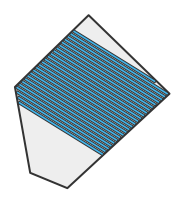

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 06:59:31 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 06:59:31 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 06:59:31 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 06:59:31 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 14 06:59:31 PM: Finished problem compilation (took 7.026e-03 seconds).
-------------------------------------------------------------------------------
                             

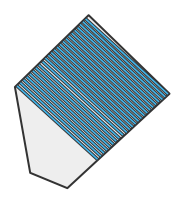

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 06:59:36 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 06:59:36 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 06:59:36 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 06:59:36 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 14 06:59:36 PM: Finished problem compilation (took 6.024e-03 seconds).
-------------------------------------------------------------------------------
                             

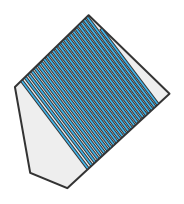

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 06:59:44 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 06:59:44 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 06:59:44 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 06:59:44 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 14 06:59:44 PM: Finished problem compilation (took 7.000e-03 seconds).
-------------------------------------------------------------------------------
                             

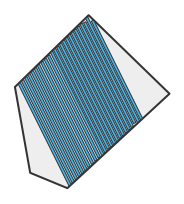

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 06:59:57 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 06:59:57 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 06:59:57 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 06:59:57 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 14 06:59:57 PM: Finished problem compilation (took 6.001e-03 seconds).
-------------------------------------------------------------------------------
                             

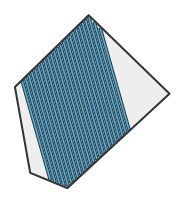

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 07:00:05 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 07:00:05 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 07:00:05 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 07:00:05 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 14 07:00:05 PM: Finished problem compilation (took 4.999e-03 seconds).
-------------------------------------------------------------------------------
                             

C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\cvxpy\problems\problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


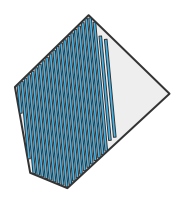

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 07:03:31 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 07:03:31 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 07:03:31 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 07:03:31 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 14 07:03:31 PM: Finished problem compilation (took 7.001e-03 seconds).
-------------------------------------------------------------------------------
                             

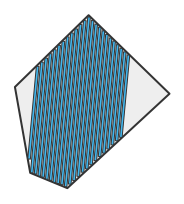

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 07:04:02 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 07:04:02 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 07:04:02 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 07:04:02 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 14 07:04:02 PM: Finished problem compilation (took 4.999e-03 seconds).
-------------------------------------------------------------------------------
                             

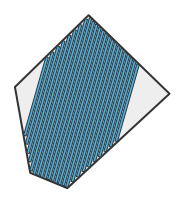

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 07:04:21 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 07:04:21 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 07:04:21 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 07:04:21 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 14 07:04:21 PM: Finished problem compilation (took 5.998e-03 seconds).
-------------------------------------------------------------------------------
                             

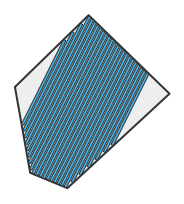

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 07:04:25 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 07:04:25 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 07:04:25 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 07:04:25 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 14 07:04:25 PM: Finished problem compilation (took 5.024e-03 seconds).
-------------------------------------------------------------------------------
                             

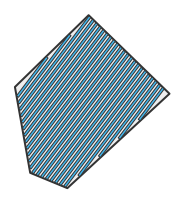

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 07:04:36 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 07:04:36 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 07:04:36 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 07:04:36 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 14 07:04:36 PM: Finished problem compilation (took 5.999e-03 seconds).
-------------------------------------------------------------------------------
                             

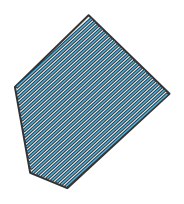

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 07:04:42 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 07:04:42 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 07:04:42 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 07:04:42 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 14 07:04:42 PM: Finished problem compilation (took 7.001e-03 seconds).
-------------------------------------------------------------------------------
                             

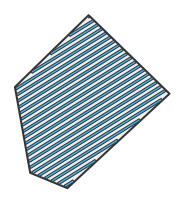

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 07:04:54 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 07:04:54 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 07:04:54 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 07:04:54 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 14 07:04:54 PM: Finished problem compilation (took 5.001e-03 seconds).
-------------------------------------------------------------------------------
                             

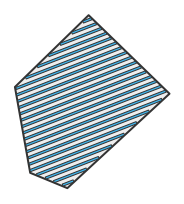

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 07:05:00 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 07:05:00 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 07:05:00 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 07:05:00 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 14 07:05:00 PM: Finished problem compilation (took 8.986e-03 seconds).
-------------------------------------------------------------------------------
                             

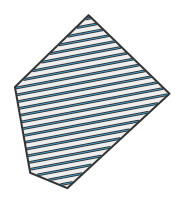

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 07:05:20 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 07:05:20 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 07:05:20 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 07:05:20 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 14 07:05:20 PM: Finished problem compilation (took 7.000e-03 seconds).
-------------------------------------------------------------------------------
                             

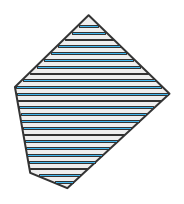

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 07:05:34 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 07:05:34 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 07:05:34 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 07:05:34 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 14 07:05:34 PM: Finished problem compilation (took 7.001e-03 seconds).
-------------------------------------------------------------------------------
                             

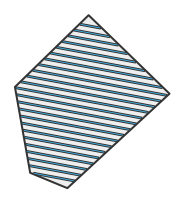

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 07:05:43 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 07:05:43 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 07:05:43 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 07:05:43 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 14 07:05:43 PM: Finished problem compilation (took 6.001e-03 seconds).
-------------------------------------------------------------------------------
                             

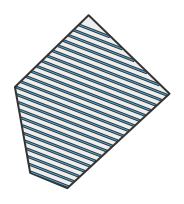

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 07:05:53 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 07:05:53 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 07:05:53 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 07:05:53 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 14 07:05:53 PM: Finished problem compilation (took 5.999e-03 seconds).
-------------------------------------------------------------------------------
                             

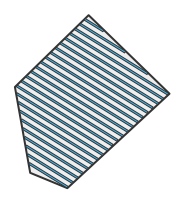

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 07:06:06 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 07:06:06 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 07:06:06 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 07:06:06 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 14 07:06:06 PM: Finished problem compilation (took 4.999e-03 seconds).
-------------------------------------------------------------------------------
                             

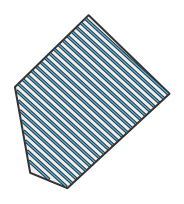

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 07:06:17 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 07:06:17 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 07:06:17 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 07:06:17 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 14 07:06:17 PM: Finished problem compilation (took 6.001e-03 seconds).
-------------------------------------------------------------------------------
                             

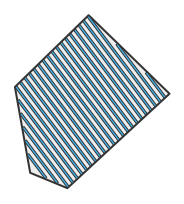

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 07:06:33 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 07:06:33 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 07:06:33 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 07:06:33 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 14 07:06:33 PM: Finished problem compilation (took 7.002e-03 seconds).
-------------------------------------------------------------------------------
                             

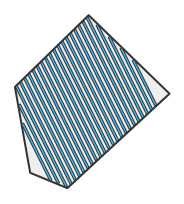

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 07:06:46 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 07:06:46 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 07:06:46 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 07:06:46 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 14 07:06:46 PM: Finished problem compilation (took 5.000e-03 seconds).
-------------------------------------------------------------------------------
                             

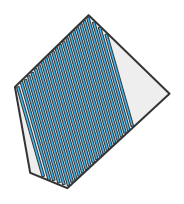

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 07:06:57 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 07:06:57 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 07:06:57 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 07:06:57 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 14 07:06:57 PM: Finished problem compilation (took 7.001e-03 seconds).
-------------------------------------------------------------------------------
                             

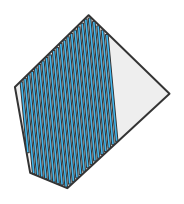

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 07:07:05 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 07:07:05 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 07:07:05 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 07:07:05 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 14 07:07:05 PM: Finished problem compilation (took 6.002e-03 seconds).
-------------------------------------------------------------------------------
                             

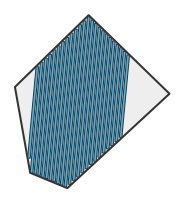

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 07:07:13 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 07:07:13 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 07:07:13 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 07:07:13 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 14 07:07:13 PM: Finished problem compilation (took 6.000e-03 seconds).
-------------------------------------------------------------------------------
                             

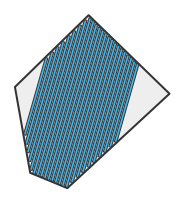

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 07:07:20 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 07:07:20 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 07:07:20 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 07:07:20 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 14 07:07:20 PM: Finished problem compilation (took 6.026e-03 seconds).
-------------------------------------------------------------------------------
                             

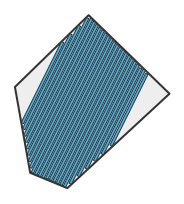

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 07:07:39 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 07:07:39 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 07:07:39 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 07:07:39 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 14 07:07:39 PM: Finished problem compilation (took 5.002e-03 seconds).
-------------------------------------------------------------------------------
                             

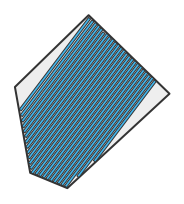

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 07:07:48 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 07:07:48 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 07:07:48 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 07:07:48 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 14 07:07:48 PM: Finished problem compilation (took 6.001e-03 seconds).
-------------------------------------------------------------------------------
                             

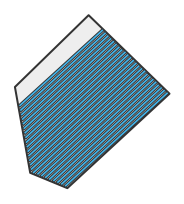

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 07:07:57 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 07:07:57 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 07:07:57 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 07:07:57 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 14 07:07:57 PM: Finished problem compilation (took 5.999e-03 seconds).
-------------------------------------------------------------------------------
                             

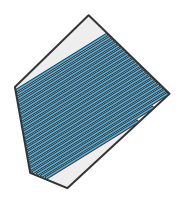

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 07:08:07 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 07:08:07 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 07:08:07 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 07:08:07 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 14 07:08:07 PM: Finished problem compilation (took 5.993e-03 seconds).
-------------------------------------------------------------------------------
                             

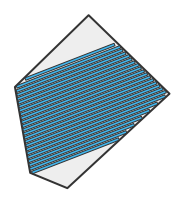

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 07:08:14 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 07:08:14 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 07:08:14 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 07:08:14 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 14 07:08:14 PM: Finished problem compilation (took 4.987e-03 seconds).
-------------------------------------------------------------------------------
                             

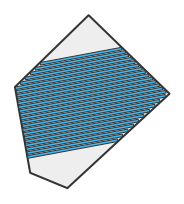

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Nov 14 07:08:21 PM: Your problem has 455 variables, 60 constraints, and 2 parameters.
(CVXPY) Nov 14 07:08:21 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 07:08:21 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 07:08:21 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 14 07:08:21 PM: Finished problem compilation (took 7.000e-03 seconds).
-------------------------------------------------------------------------------
                             

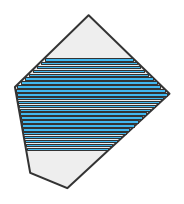

Optimal layout plot, Azmth: 180.00, Tilt: 44.34


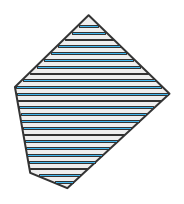

In [8]:
'''
GAMMA-ITERATIVE PROCESS (CVXPY) 2
'''
# Max number of arrays
n = N(P, H, D_OFF)

# Piecewise linear circle approximation
angles = np.linspace(0,np.pi/2,K)
L = np.block([[np.zeros(2)], [np.cos(angles[:,None]), np.sin(angles[:,None])]])
Al, bl, ll, lu = vert2con(L)
non_ort_indices = np.argsort(bl)[0,2:]
Al, bl = Al[non_ort_indices], bl[:,non_ort_indices]
ll, lu = ll[non_ort_indices], lu[non_ort_indices]

# big-M
bigMm = diameter(P) // W
bigMu = np.sum(Al,1,keepdims=True)
bigMd = H*(np.cos(tilt_hat) + np.sin(tilt_hat)/np.tan(elev_min)) + D_OFF

# Matrices 
O = np.vstack([np.zeros(n), np.tril(np.ones([n,n]))])
Ao, bo, _, _ = vert2con(O)
Ah, bh, _, _ = vert2con(P)

# Variables
variables = {'x', 'y', 'm', 'z', 'w', 'u'}
x = cp.Variable((n,4), name="x")
y = cp.Variable((n,4), name="y")
m = cp.Variable((n,1), integer=True, name="m")
z = cp.Variable((n,1), boolean=True, name="z")
w = cp.Variable((K-1,1), boolean=True, name="w")
u = cp.Variable((2,1), nonneg=True, name="u") # sin(tilt), cos(tilt)

# Parameters
parameters = {'v'}
v = cp.Parameter(2, value=[0,-1], name="v") 
  
# Expressions
expressions = {'csge', 'shad', 'dist', 'paoi', 'beam', 'diff', 'grnd', 'area', 'irrd', 'treq', 'cost', 'power', 'log_power'} 
csge = cp.multiply(np.cos(sun_azmth),v[1]) + cp.multiply(np.sin(sun_azmth),v[0])
#shad = H*(u[1,0] + u[0,0]*csge/np.tan(sun_elev))
shad = H*(u[1,0] + u[0,0]/np.tan(elev_min))
dist = v[0]*(x[:-1,0] - x[1:,0]) + v[1]*(y[:-1,0] - y[1:,0])
paoi = cp.multiply(u[1,0], np.sin(sun_elev)) + cp.multiply(u[0,0], cp.multiply(np.cos(sun_elev),csge))
beam = cp.multiply(dni, paoi)
diff = 0.5*dhi*(1 + u[1,0])
grnd = 0.5*ALB*ghi*(1 - u[1,0]) 
area = W*H*cp.sum(m)
irrd = beam + diff + grnd
treq = cp.sum_squares(u)
cost = area*CP + cp.sum(z)*CR

power     = cp.multiply(area, irrd) # non-convex, only for analysis
log_power = cp.log(area) + cp.log(irrd)

# Constraints
constraints = [
    # Array coordinates 
    x[:,1] == x[:,0] - v[1]*W*m[:,0], y[:,1] == y[:,0] + v[0]*W*m[:,0],
    x[:,2] == x[:,1] - v[0]*H*u[1,0], y[:,2] == y[:,1] - v[1]*H*u[1,0],
    x[:,3] == x[:,0] - v[0]*H*u[1,0], y[:,3] == y[:,0] - v[1]*H*u[1,0],
    # Array ordering
    Ao @ z <= bo.T,
    # Trigonometric approximation 
    Al @ u <= bl.T + cp.multiply((1 - w),bigMu), 
    Al @ u >= cp.multiply(bl.T,w),
    u.T >= cp.sum(cp.multiply(ll, w),0,keepdims=True), 
    u.T <= cp.sum(cp.multiply(lu, w),0,keepdims=True),
    cp.sum(w) == 1,
    # z-m logic constraints
    m <= bigMm*z, 
    m >= z,
    # Arrays' inside polygon
    Ah @ cp.vstack([cp.vec(x), cp.vec(y)]) <= np.kron(np.ones(4*n), bh.T),
    cp.sum(z) == 24
]
# TODO: why does it gets slow if I write them directly in constraints?
for i in range(n-1):
    constraints += [dist[i] >= shad + D_OFF - bigMd*(1-z[i+1,0])]
        
# Problem type
if PROBLEM_TYPE == "power":
    objective = cp.Minimize(-cp.min(log_power))
elif PROBLEM_TYPE == "area":
    # avg_m    = cp.sum(m) / n 
    # avg_dist = cp.sum(dist) / (n-1) 
    # var_m    = cp.sum_squares(m - avg_m)
    # var_dist = cp.sum_squares(dist - avg_dist)
    coeff = 0.01
    objective = cp.Minimize(coeff*cost + (1 - coeff)*(cp.sum(x) + cp.sum(y)))
    constraints += [log_power >= np.log(power_spec)] # Power requirements

# Compile 
prob = cp.Problem(objective, constraints)

# Iterative process
best_obj = np.inf
for g in np.linspace(0, 2*np.pi, S):
    v.value = [np.sin(g), np.cos(g)]
    solver_results = prob.solve(solver=cp.MOSEK, mosek_params=MOSEK_PARAMS, verbose=VERBOSE)
    
    # Save the problem variables, parameters and expressions
    if prob.value < best_obj:
        best_obj = prob.value
        results = {name: globals()[name].value for name in variables | parameters | expressions}
        results["tilt"]  = np.arctan(u[0,0].value/u[1,0].value)
        results["azmth"] = g
        
    print(f"- Array azmth: {np.rad2deg(g):.2f}°")
    
    # Plotting 
    plot_layout(x.value, y.value, z.value, P) 
    
# JSON serialize results and save layout figure
with open(f"results/{PROBLEM_NAME}_{PROBLEM_TYPE}.json", "w") as file:
    json.dump(results, file, default=lambda x: x.tolist())

# Plot optimal layout
print(f"Optimal layout plot, Azmth: {np.rad2deg(results['azmth']):.2f}, Tilt: {np.rad2deg(results['tilt']):.2f}")
plot_layout(results["x"], results["y"], results["z"], P, 
            savepath=f"fig/{PROBLEM_NAME}_{PROBLEM_TYPE}.pdf")

# GeoJSON serialize the layout (in WSG84)
wgs84_x, wgs84_y  = Transformer.from_crs(sinus, wgs84) \
                               .transform(results["x"] + center[0], results["y"] + center[1])
arrays = rectangles(wgs84_y, wgs84_x, results["z"])
with open(f"area/{PROBLEM_NAME}_layout_{PROBLEM_TYPE}.geojson", "w") as file:
    multi_polygon = geojson.MultiPolygon([[np.vstack([array, array[0]]).tolist()] for array in arrays])
    json.dump(multi_polygon, file)

In [10]:
'''
Load results
'''

with open("results/vasto_giardinetto_power.json", "r") as file:
    results = json.load(file)
    
print(f'Tilt: {np.rad2deg(results["tilt"])}')
print(f'Azmth: {np.rad2deg(results["azmth"])}')

Tilt: 44.34079068454252
Azmth: 180.0


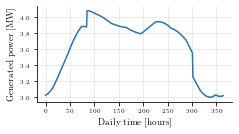

In [15]:
'''
Generated power (Problem type "area")
'''

fig, ax = plt.subplots(figsize=(FIGSIZE_COL_WIDTH,0.5*FIGSIZE_COL_WIDTH))
gen     = 1e-3*results["power"] # in MW
avg_gen = np.mean(gen,0)
min_gen = np.min(gen,0)
max_gen = np.max(gen,0)
# ax.plot(1e-3*power_spec)
ax.plot(gen)
# ax.fill_between(np.arange(365), min_gen,max_gen, 
#                 alpha=0.1, color="tab:orange")
ax.set_xlabel("Daily time [hours]")
ax.set_ylabel("Generated power [MW]")
ax.grid(alpha=0.3, zorder=0)
plt.show(block=False)

In [8]:
'''
NON-CONVEX GLOBAL FORMULATION (PYOMO)
'''
n = N(P, H, D_OFF)

ml = pyo.ConcreteModel("Non-convex PVALOP")

# Matrices for "in_polygon" and "z"
O = np.vstack([np.zeros(n), np.tril(np.ones([n,n]))])
Ao, bo, _, _ = vert2con(O)
Ah, bh, _, _ = vert2con(P)
x_max, x_min = np.max(P[:,0]), np.min(P[:,0])
y_max, y_min = np.max(P[:,1]), np.min(P[:,1])

# Piecewise linear circle approximation
angles = np.linspace(0,np.pi/2,K)
L = np.block([[np.zeros(2)], [np.cos(angles[:,None]), np.sin(angles[:,None])]])
Al, bl, ll, lu = vert2con(L)
non_ort_indices = np.argsort(bl)[0,2:]
Al, bl = Al[non_ort_indices], bl[:,non_ort_indices]
ll, lu = ll[non_ort_indices], lu[non_ort_indices]

# Ranges
ml.N = pyo.RangeSet(n)
ml.T = pyo.RangeSet(T)
ml.B = pyo.RangeSet(2) # for binary stuff
ml.C = pyo.RangeSet(4) # arrays corners
ml.V = pyo.RangeSet(V)

# Parameters
ml.CP = pyo.Param(initialize=CP)
ml.CR = pyo.Param(initialize=CR)
ml.a  = pyo.Param(ml.T, initialize={t:sun_elev[t-1] for t in ml.T}, name="a")
ml.e  = pyo.Param(ml.T, initialize={t:sun_azmth[t-1] for t in ml.T}, name="e")
ml.bm = pyo.Param(ml.T, initialize={t:dni[t-1] for t in ml.T}, name="bm")
ml.df = pyo.Param(ml.T, initialize={t:dhi[t-1] for t in ml.T}, name="df")
ml.gr = pyo.Param(ml.T, initialize={t:ghi[t-1] for t in ml.T}, name="gr")
ml.pt = pyo.Param(ml.T, initialize={t:power_spec[t-1] for t in ml.T}, name="pt")
ml.of = pyo.Param(initialize=D_OFF, name="of")
ml.Md = pyo.Param(initialize=H*(np.cos(tilt_hat) + np.sin(tilt_hat)/np.tan(elev_min)) + D_OFF, name="Md")
ml.Mm = pyo.Param(initialize=diameter(P) // W, name="Mm")

ml.min_a = pyo.Param(initialize=elev_min)

# Variables
ml.x = pyo.Var(ml.N, ml.C, bounds=[x_min,x_max], name="x")
ml.y = pyo.Var(ml.N, ml.C, bounds=[y_min,y_max], name="y")
ml.m = pyo.Var(ml.N, domain=pyo.NonNegativeReals, bounds=[0, ml.Mm], name="m")
ml.z = pyo.Var(ml.N, domain=pyo.Binary, name="z")
ml.u = pyo.Var(ml.B, domain=pyo.NonNegativeReals, bounds=[0,1], name="u")
ml.v = pyo.Var(ml.B, domain=pyo.Reals, bounds=[-1,1], name="v")

ml.min_power = pyo.Var(domain=pyo.NonNegativeReals)

# Expressions
ml.area = H*W*sum([ml.m[i] for i in ml.N])
ml.cost = sum([ml.CP*ml.m[i] + ml.CR*ml.z[i] for i in ml.N])
ml.tilt = pyo.atan(ml.u[1]/ml.u[2])
ml.azmt = pyo.atan(ml.v[1]/ml.v[2])

ml.csge = pyo.Expression(ml.T,
    rule=lambda ml,t: pyo.cos(ml.e[t])*ml.v[2] + pyo.sin(ml.e[t])*ml.v[1]
)
ml.shad = pyo.Expression(
    rule=lambda ml,t: H*(ml.u[2] + ml.u[1]/pyo.tan(ml.min_a))
)
ml.dist = pyo.Expression(pyo.RangeSet(n-1), 
    rule=lambda ml,i: ml.v[1]*(ml.x[i,1] - ml.x[i+1,1]) + ml.v[2]*(ml.y[i,1] - ml.y[i+1,1])
)
ml.paoi = pyo.Expression(ml.T, 
    rule=lambda ml,t: ml.u[2]*pyo.sin(ml.a[t]) + ml.u[1]*pyo.cos(ml.a[t])*ml.csge[t]
)
ml.pbm = pyo.Expression(ml.T,
    rule=lambda ml,t: ml.paoi[t]*ml.bm[t]
)
ml.pdf = pyo.Expression(ml.T, 
    rule=lambda ml,t: 0.5*ml.df[t]*(1 + ml.u[2])
)
ml.pgr = pyo.Expression(ml.T,
    rule=lambda ml,t: 0.5*ALB*ml.gr[t]*(1 - ml.u[2])
)
ml.pirr = pyo.Expression(ml.T,
    rule=lambda ml,t: ml.pbm[t] + ml.pdf[t] + ml.pgr[t]
)
ml.power = pyo.Expression(ml.T,
    rule=lambda ml,t: ml.area*ml.pirr[t]
)

# Constraints
ml.in_polygon = pyo.Constraint(
    ml.N, ml.V, ml.C,
    rule=lambda ml,i,j,c: sum([Ah[j-1,0]*ml.x[i,c] + Ah[j-1,1]*ml.y[i,c]]) <= bh[0,j-1]
)

ml.rects   = pyo.ConstraintList()
ml.m_logic = pyo.ConstraintList()
for i in ml.N:
    ml.rects.add(expr=ml.x[i,2] == ml.x[i,1] - ml.v[2]*W*ml.m[i])
    ml.rects.add(expr=ml.y[i,2] == ml.y[i,1] + ml.v[1]*W*ml.m[i])
    ml.rects.add(expr=ml.x[i,3] == ml.x[i,2] - ml.v[1]*H*ml.u[2])
    ml.rects.add(expr=ml.y[i,3] == ml.y[i,2] - ml.v[2]*H*ml.u[2])
    ml.rects.add(expr=ml.x[i,4] == ml.x[i,1] - ml.v[1]*H*ml.u[2])
    ml.rects.add(expr=ml.y[i,4] == ml.y[i,1] - ml.v[2]*H*ml.u[2])
    ml.m_logic.add(expr=ml.m[i] >= ml.z[i])
    ml.m_logic.add(expr=ml.m[i] <= ml.Mm*ml.z[i])
    
ml.z_order = pyo.Constraint(
    pyo.RangeSet(n+1), 
    rule=lambda ml,n: sum([Ao[n-1,i-1]*ml.z[i] for i in ml.N]) <= bo[0,n-1]
)
          
ml.trig_nonconvex = pyo.ConstraintList()
ml.trig_nonconvex.add(expr=ml.u[1]**2 + ml.u[2]**2 == 1)
ml.trig_nonconvex.add(expr=ml.v[1]**2 + ml.v[2]**2 == 1)
    
ml.min_dist = pyo.Constraint(
    pyo.RangeSet(n-1), 
    rule=lambda ml,i: ml.dist[i] >= ml.shad + ml.of - (1 - ml.z[i+1])*ml.Md
)

ml.min_power_const = pyo.Constraint(
    ml.T,
    rule=lambda ml,t: ml.min_power <= ml.power[t] 
)

ml.power_specs = pyo.Constraint(
    ml.T,
    rule=lambda ml,t: ml.power[t] >= ml.pt[t] 
)

# Objectives
if PROBLEM_TYPE == "power":
    ml.objective = pyo.Objective(rule=ml.min_power, sense=pyo.maximize)
    ml.power_specs.deactivate()
elif PROBLEM_TYPE == "area":
    ml.objective = pyo.Objective(rule=ml.cost + pyo.summation(ml.x) + pyo.summation(ml.y), sense=pyo.minimize)
    
scip = pyo.SolverFactory(
    'scip', 
    executable=r"C:\Program Files\SCIPOptSuite 8.0.2\bin\scip.exe")
results = scip.solve(ml, options=SCIP_PARAMS, tee=True)

SCIP version 8.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: Soplex 6.0.2] [GitHash: 5f0473c4fb]
Copyright (C) 2002-2022 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External libraries: 
  Soplex 6.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 45f6420d]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (github.com/coin-or/CppAD)
  MPIR 3.0.0           Multiple Precision Integers and Rationals Library developed by W. Hart (mpir.org)
  ZIMPL 3.5.3          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  AMPL/MP 4e2d45c4     AMPL .nl file reader library (github.com/ampl/mp)
  PaPILO 2.1.1         parallel presolve for integer and linear optimization (github.com/scipopt/papilo) [GitHash: 01fada2]
  bliss 0.77           Computing Graph Automorphism Groups by T. Junttila and P. Kaski (www.tcs.hut.fi/Software/bliss/)
  Ipopt 

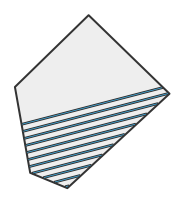

In [9]:
'''
Get PYOMO results
'''

x = np.array([[ml.x[i,j].value for j in ml.C] for i in ml.N])
y = np.array([[ml.y[i,j].value for j in ml.C] for i in ml.N])
z = np.array([[ml.z[i].value] for i in ml.N])

plot_layout(x, y, z, P) 

### Miscellaneous

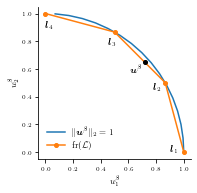

In [9]:
# Trigonometric inequality approximation

K = 4
t = np.arange(0,np.pi/2,0.1)
a = np.linspace(0,np.pi/2,K)
b = 0.6
p = np.array([
    b*np.cos(a[1]) + (1-b)*np.cos(a[2]), 
    b*np.sin(a[1]) + (1-b)*np.sin(a[2])
])

fig, ax = plt.subplots(figsize=(0.8*FIGSIZE_COL_WIDTH,0.8*FIGSIZE_COL_WIDTH))
ax.plot(np.cos(t),np.sin(t), label=r"$\|\boldsymbol{u}^\beta\|_2=1$")
ax.plot(np.cos(a),np.sin(a), label=r"$\text{fr}(\mathcal{L})$", marker="o", markersize=4)
ax.plot(*p, color="k", marker="o", markersize=4)
ax.set_aspect('equal')
plt.xlabel(r"$u^{\beta}_1$")
plt.ylabel(r"$u^{\beta}_2$")
ax.text(*(p-0.03), r"$\boldsymbol{u}^\beta$",
        horizontalalignment="right", verticalalignment="top")
for i in range(K):
    ax.text(0.9*np.cos(a[i]),0.9*np.sin(a[i]), r"$\boldsymbol{l}_" + f"{i+1}$")
ax.legend()

plt.savefig("fig/trig_approx.pdf", bbox_inches='tight')
plt.show(block=False)

In [ ]:
# Location irradiance plot
labels = [r"$r^\text{bm}$", r"$r^\text{df}$", r"$r^\text{gr}$"]
fig, ax = plt.subplots(figsize=(FIGSIZE_COL_WIDTH, 0.5*FIGSIZE_COL_WIDTH))
for i, irr_type in enumerate(daily_irr.values()):
    mean_irr_type = np.mean(irr_type, 0)
    max_irr_tpye  = np.max(irr_type, 0)
    min_irr_tpye  = np.min(irr_type, 0)
    ax.plot(mean_irr_type, label=labels[i])
    ax.fill_between(np.arange(24), min_irr_tpye, max_irr_tpye, alpha=0.1)
ax.grid(alpha=0.3, zorder=0)
plt.xlabel("Daily time (hours)")
plt.ylabel("Irradiance " + r"$\left(\frac{\text{kW}}{\text{m}^2}\right)$")
plt.legend(loc="upper right")

plt.savefig("fig/irradiance.pdf", bbox_inches='tight')
plt.show(block=False)

In [ ]:
# Plot solar data (https://pvlib-python.readthedocs.io/en/v0.9.0/auto_examples/plot_sunpath_diagrams.html)
solpos = solar_position.loc[solar_position['apparent_elevation'] > 0, :]
fig    = plt.figure(figsize=(FIGSIZE_COL_WIDTH, FIGSIZE_COL_WIDTH))
ax     = plt.subplot(1, 1, 1, projection='polar')
# draw the analemma loops
points = ax.scatter(np.radians(solpos.azimuth), solpos.apparent_zenith,
                    s=2, label=None, c=solpos.index.dayofyear, cmap="binary")

# draw hour labels
for hour in np.unique(solpos.index.hour):
    # choose label position by the smallest radius for each hour
    subset = solpos.loc[solpos.index.hour == hour, :]
    r = subset.apparent_zenith
    pos = solpos.loc[r.idxmin(), :]
    ax.text(np.radians(pos['azimuth']), pos['apparent_zenith'], str(hour))

# draw individual days
colors = ["tab:blue", "tab:orange", "tab:green"]
styles = ["-", "--", "-"] 
for i,date in enumerate(pd.to_datetime(['2021-12-21', '2022-03-21', '2022-06-21'])):
    times = pd.date_range(date, date+pd.Timedelta('24h'), freq='5min', tz=TZ)
    solpos = location.get_solarposition(times)
    solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]
    label = date.strftime('%Y-%m-%d')
    ax.plot(np.radians(solpos.azimuth), solpos.apparent_zenith, label=label, 
            color=colors[i], linestyle=styles[i], linewidth=1.5)

ax.figure.legend(loc='lower center', ncol=3, borderaxespad=0, fontsize=8)

# change coordinates to be like a compass
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_rmax(90)

plt.savefig("fig/sunpath.pdf", bbox_inches='tight')
plt.show(block=False)